# [선형회귀분석 실습 4: 실전]

## 모듈 불러오기

In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pylab

from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#plt.rc('font', family='Malgun Gothic')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

## 데이터 불러오기

### Toyota Corolla Data
### 중고차 가격(Price)를 예측하기 위한 예측모델 학습

In [2]:
data = pd.read_csv('Data/ToyotaCorolla.csv')
data.head()
#pd=pandas의 read_csv를 이용해서 데이터를 데이터프레임 형태로 불러온다.
#ToyotaCorolla 데이터를 불러오는 코드이다. 
#head는 데이터의 일부분을 보여준다
#관련된 변수 정보들이 있는 것을 볼 수 있다. 
#Price가 Y이고 나머지가 X들인 것이다.

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0


In [3]:
type(data)
data.shape
#데이터는 1436개가 있고 변수는 37개가 있다는 것

(1436, 37)

## 데이터 전처리하기
### 1. 예측에 필요하지 않은 변수 제거

In [4]:
#어떤 것이 필요없는 것인 지 모르겠지만 선형회귀는 데이터가 숫자로 되어 있는 것
#연속형인 것에 적용이 되니까 categorical,또는 문자로 있는 변수들을 제거하든지
#다른 조치를 취해야 하는데 여기서는 제거하도록 하겠다. 위의 data를 보면 ID같은 
#것들은 필요없으니 제거하도록 하겠다.
data=data.drop(['Id','Model','Fuel_Type'], axis=1)
data.head()
#drop은 변수나 observation를 제거할 수 있다. 
#Fuel_Type은 의미 있을 수 있지만 문자이기 때문에 제거한다. axis는
#제거를 어떤 기준으로 하냐이다. 0으로 한다는 것은 Row기준으로 본다는 것이고
#1이면 column기준으로 보는 것이다. column기준으로 이 변수들이 있을 테니
#이 변수들을 제거해라 라는 것이다. 
#제거하고 나면 이렇게 숫자로 된 데이터만 남게 된다.

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,13500,23,10,2002,46986,90,1,0,2000,3,...,1,1,1,0,0,0,1,0,0,0
1,13750,23,10,2002,72937,90,1,0,2000,3,...,1,0,1,0,0,0,1,0,0,0
2,13950,24,9,2002,41711,90,1,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
3,14950,26,7,2002,48000,90,0,0,2000,3,...,0,0,1,0,0,0,1,0,0,0
4,13750,30,3,2002,38500,90,0,0,2000,3,...,1,1,1,0,1,0,1,0,0,0


### 2. 학습 데이터와 테스트 데이터로 분리

In [5]:
#학습 데이터와 테스트 데이터로 분리하라고 했는데 이것을 도와주는 패키지가 있다.
#이 패키지는 sklearn.model_selection에서 import해서 이 함수를 사용한다
#첫 번째 파라미터에 data를 놓아도 되고 X와 Y로 나눴다면
#train_data, test_data=train_test_split(X,Y, test_size=0.3, random_state=55)
#이렇게 해도 무방하다
#그리고 기본적으로 옵션이 있는데 두 번째 파라미터를 보면 0.3이라는 것은
#30%를 테스트 데이터로 사용하겠다는 것이다. 
train_data, test_data=train_test_split(data, test_size=0.3, random_state=12556)
#train_data와 test_data 이렇게 리턴 값이 2개니까 콤마로 분리 시켜준다.
#다만 random_state는 이 테스트 데이터 0.3를 랜덤하게 뽑는 것인데
#random_state는 seed라고 생각하면 된다.

## 모델링

### 학습 데이터를 이용하여 선형회귀모델 학습

In [6]:
type(train_data)
#train_data의 타입은 DataFrame인 것을 볼 수 있다.
#우리가 항상 확인해야 할것은 어떤 함수는 input으로 DataFrame를 넣었는데
#array로 뱉어줄 수 있고 굉장히 다양하다. 항상 확인해야 한다. 
#그것이 파이썬의 단점이기도 하다(너무 자유로워서)


pandas.core.frame.DataFrame

In [7]:
#DataFrame의 특징 중 하나는 우리가 특정 변수를 뽑아서 쓸 수 있다는 것이다. 
train_data['Price']
train_data['Age_08_04']
#위와 같이 특정 변수를 뽑아서 쓸 수가 있다.

647     68
1170    78
1244    70
846     63
415     55
        ..
368     37
1333    75
57      26
1019    64
1356    77
Name: Age_08_04, Length: 1005, dtype: int64

In [8]:
#선형회귀 모델은 가장 많다 구글에서 linear regression in python를 검색하면
#기본적으로 sklearn에서 제공하는 모델도 있고 굉장히 많다.
#교수님은 sklearn보단 statsmodel를 쓴다. 이 패키지를 누가 만들어서 제공한 것이다.
#이게 더 좋은 정보들을 준다고 생각한다. 선형회귀는 통계학자들이 보는
#통계들을 더 잘 보여주니까 이것을 쓴다. 이 statsmodel 사이트에 들어가서
#참고하면 된다. 
lm=sm.OLS(train_data['Price'], train_data.drop('Price', axis=1))
lm_trained=lm.fit()
#statsmodel에서는 Linear Regression을 학습 시킬 때 OLS방식으로 학습 시킨다.
#OLS으로 학습 시키는 것이 있고 GLs, WLS, GLSAR등등이 있는데 OLS는 
#우리가 아는 Least Square Estimation 방법으로 학습을 시키는 방법이다.
#나머지는 좀 복잡한 Linear Regression 모델들이다. 
#이 함수의 첫 번째 파라미터로는 어떤 것을 Y로 넣겠냐는 것이다. 그래서 여기선
#train_data에서 'Price' 데이터로 설정하고 있다.
#두 번째 파라미터를 보면 'Price'를 제거하고 나머지 변수들이니까 이 drop 함수를
#이용해서 이렇게 X변수들을 모아놨다.
#그리고 이제 lm으로 fitting을 시킬지 또는 predict를 할지 결정하는데
#여기서는 fitting를 하기로 한다. 
#fitting를 하면 train데이터로 학습이 된 것이다. 

In [9]:
#다른 방식으로도 똑같은 코드를 구현할 수 있다
train_data.iloc[:,0]
#위의 코드는 Y를 의미하는데 이것을 대신 넣어서 아래와 같이 해도 된다
#iloc은 인덱스를 이용한 방법이다.
"""
lm=sm.OLS(train_data.iloc[:,0],train_data.drop('Price',axis=1))
lm_trained=lm.fit()
"""

"\nlm=sm.OLS(train_data.iloc[:,0],train_data.drop('Price',axis=1))\nlm_trained=lm.fit()\n"

### 모델 학습 결과 (Summary) 확인

In [10]:
#fitting를 하고나면 이렇게 summary를 뱉어준다.
#이 학습된 모델에서 다양한 함수를 쓸 수 있는데 그중 하나가 summary()이다
#이것을 보면 시험 문제에 나왔던 테이블을 뱉어주게 된다
#이거 말고도 다른 정보들도 보여줄 수 있는데 그건 패키지를 잘 숙지하고 있어야
#된다. 
#결과를 보면 Method: Least Squares 방식으로 학습했다는 것이고
#R-sqared:0.92다 굉장히 높다.(의미가 있다)
#F-statistic:375.5이다. 매우 높다(즉 귀무가설을 기각하게 된다.) 즉
#대립가설로는 모든 변수의 기울기가 0이냐 아니냐 이런걸 결정하는 것이고
#Prob(F-statistic) 즉 F-statistic의 p-value를 보면 0.00이 나온다
#너무 작아서 0으로 둔 거인데 이것은 즉 우리의 Linear Regression 모델이 
#의미가 있구나 라고 확인해 볼 수 있다. 

#그리고 두 번째 표를 보면 coef들이 다 표시되어 있고 이 Age를 보면 음의 관계가
#있다 즉 에이지가 높아지면 높아질 수록 Price는 떨어지는 구나 이런 것을
#살펴볼 수 있다. 그리고 이것에 대한 각각 가설검정한 것을 보면 P>|t|(p-value)가
#있는데 우리가 기준을 뭘로 잡든 간에 0.05로 잡으고 이것을 확인해 보면
#Met_Color(0.193), Automatic(0.188), cc(0.072), Doors(0.708), Gears(0.276)
#Quarterly_Tax(0.356), Airbag_1(0.192), Airbag_2(0.234), Airco(0.354) 등등
#굉장히 많은 변수들이 의미가 없다고 나온다. 이런 변수들이 의미가 없더라
#라고 나오는 것을 확인했고 나머지 변수들은 0.05로 놓냐 0.01에 놓냐에 따라서
#달라진다. 가령 Sports_Model(0.021) 변수를 보면 내가 기준을 0.01로 놓으면
#의미가 없어지게 되고 0.05로 놓으면 의미가 있게 된다. 
#귀무가설을 기각하냐 안 기각하냐로 따져볼 수도 있지만 어떤 문제냐에 따라서
#다르다. 예를 들어 우리가 예측하는 문제다. 나중에 새로운 데이터가 왔을 때
#예측을 잘하려고 한다 라고 하면 예측 퍼포먼스를 먼저 살펴봐야 한다.
#귀무가설을 한다음에 변수를 다시 지우고 모델링하기 전에 이 변수가 비록
#통계적으로 무의미하더라도 예측 퍼포먼스 관점에서는 유의미할 수 있다
#이것을 확인해 봐야한다. 내가 예측을 잘하고 싶다면 통계적으로 무의미해도
#퍼포먼스를 살펴볼 필요가 있다 이것을 살펴보기 위해서 아래에서 
#MSE, RMSE, MAE, MAPE를 계산해본다.
lm_trained.summary()

#여기 나온 R-squared는 training 데이터에 대한 R-squared이다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     319.7
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        18:55:54   Log-Likelihood:                -8453.9
No. Observations:                1005   AIC:                         1.697e+04
Df Residuals:                     973   BIC:                         1.713e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age_08_04         -113.6158      4.220    -26.926      0.000    -121.896    -105.335
Mfg_Month          -97.6033     10.868     -8.981      0.000    -118.931     -76.276
Mfg_Year             1.1089      0.808      1.373      0.170      -0.476       2.694
KM                  -0.0189      0.001    -15.304      0.000      -0.021      -0.016
HP                  25.4256      2.895      8.783      0.000      19.745      31.106
Met_Color          -47.7078     79.287     -0.602      0.548    -203.300     107.885
Automatic          281.9255    162.192      1.738      0.082     -36.361     600.211
cc                  -0.1233      0.077     -1.593      0.112      -0.275       0.029
Doors               70.0844     41.131      1.704      0.089     -10.631     150.800
Cylinders           -0.0329      0.002    -14.590      0.000      -0.037      -0.028
Gears              157.9460    193.654      0.816      0.415    -222.081     537.973
Quarterly_Tax        8.0747      1.405      5.747      0.000       5.318      10.832
Weight              10.7658      1.240      8.679      0.000       8.331      13.200
Mfr_Guarantee      301.5849     77.850      3.874      0.000     148.812     454.358
BOVAG_Guarantee    650.8041    134.737      4.830      0.000     386.396     915.212
Guarantee_Period    62.8690     13.890      4.526      0.000      35.611      90.127
ABS               -428.9838    134.615     -3.187      0.001    -693.153    -164.814
Airbag_1           231.3770    255.189      0.907      0.365    -269.407     732.161
Airbag_2            17.6739    135.905      0.130      0.897    -249.027     284.375
Airco              253.3518     93.260      2.717      0.007      70.338     436.366
Automatic_airco   2727.6029    206.722     13.195      0.000    2321.931    3133.274
Boardcomputer     -340.2600    124.721     -2.728      0.006    -585.013     -95.507
CD_Player          272.2658    106.472      2.557      0.011      63.324     481.207
Central_Lock      -118.2204    153.811     -0.769      0.442    -420.060     183.619
Powered_Windows    431.1869    153.454      2.810      0.005     130.049     732.325
Power_Steering    -200.6083    277.041     -0.724      0.469    -744.275     343.058
Radio              523.3755    657.718      0.796      0.426    -767.334    1814.085
Mistlamps          -16.9414    115.918     -0.146      0.884    -244.420     210.538
Sport_Model        278.1681     92.340      3.012      0.003      96.960     459.376
Backseat_Divider   -66.7686    131.623     -0.507      0.612    -325.067     191.530
Metallic_Rim        39.6216    100.177      0.396      0.693    -156.966     236.209
Radio_cassette    -602.9474    658.553     -0.916      0.360   -1895.295     689.400
Tow_Bar           -248.8921     84.729     -2.938      0.003    -415.165     -82.619
=======================

## 예측성능 평가

### 1. 학습 데이터셋에 대한 예측성능 평가
MSE, RMSE, MAE, MAPE 계산하여 성능 확인

In [11]:
#여러 가지 관점에서 볼 수 있다. 우리가 나중에 어떤 문제를 풀때는
#우리가 생각했을 때 유의미한 지표를 사용하면 된다 또는
#특히 어떤 지표가 유의미한지 모르겠다면 전체적으로 살펴볼 수도 있다

#아까 학습한 모델이 lm_trained 이였는데 이것은 fitting하고 나면
#predict함수를 제공한다. 이것을 이용해서 예측을 하는데
#test data가 아닌 training 데이터에 대해서 한 번 해보겠다
#여기에다가 인풋 데이터를 넣어주면 이 predict를 통해서 output를
#예측을 하는데 여기선 'Price' 변수를 제외한 나머지 변수를 input으로 넣었다.
#
train_pred = lm_trained.predict(train_data.drop(['Price'], axis=1))

#mean_squared_error 함수를 보면 첫 번째 input값으로는 실제 값, 그리고 두 번째
#input으로는 예측값을 넣는다
#이 MSE는 sklearn.metrics import mean_squared_err, mean_absolute_error에서
#가져와서 사용한다. 모르면 구글링해서 자세히 본다
#
print('Training MSE: {:.3f}'.format(mean_squared_error(train_data['Price'], train_pred)))
print('Training RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(train_data['Price'], train_pred))))
print('Training MAE: {:.3f}'.format(mean_absolute_error(train_data['Price'], train_pred)))
print('Training MAPE: {:.3f}'.format(mean_absolute_percentage_error(train_data['Price'], train_pred)))


#교수님은 영상에서 
#Training MSE: 1185545.152
#Training RMSE: 1088.827
#Training MAE: 812.589
#Training MAPE: 8.264
#가 나오는데 나랑 왜 다른 지 모름

#MSE, RMSE, MAE는 해석하기 어렵고 MAPE만 보면
#한 8퍼센트, 실제 데이터 대비 한 8퍼센트를 Linear regression 모델이
#예측을 잘 못하는 것을 볼 수 있다. 나름 예측을 잘하는 것이다
#누구한텐 작고 클 수도 있지만 그냥 나쁘지 않지 않을까 개인적으로 생각이 든다
#나머지는 이 값들이 굉장히 큰데 이 price 단위가 굉장히 커서 그런듯 싶다


Training MSE: 1185545.152
Training RMSE: 1088.827
Training MAE: 812.589
Training MAPE: 8.264


In [12]:
train_data['Price']
max(train_data['Price'])
# 단위가 지금 크기 때문에 MSE나 MAE나 RMSE가 큰 것이다.
# 절대적인 값만 보고 너무 크다고 생각하면 안 된다.
#MAPE가 8퍼센트인데 기본적으로는 작은 percentile이니까 어느 정도 잘 맞고 있구나 라고 생각할 수 
#있다.

32500

### 2. 테스트 데이터셋에 대한 예측성능 평가
MSE, RMSE, MAE, MAPE 계산하여 성능 확인

In [15]:
test_pred=lm_trained.predict(test_data.drop(['Price'], axis=1))
print('Testing MSE: {:.3f}'.format(mean_squared_error(test_data['Price'], test_pred)))
print('Testing RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(test_data['Price'], test_pred))))
print('Testing MAE: {:.3f}'.format(mean_absolute_error(test_data['Price'], test_pred)))
print('Testing MAPE: {:.3f}'.format(mean_absolute_percentage_error(test_data['Price'], test_pred)))

##Training이랑 비교했을 때 큰 차이가 없으니까 크게 오버피팅도 발생하지 않았다고
#생각할 수 있다. 

Testing MSE: 1423634.572
Testing RMSE: 1193.162
Testing MAE: 880.221
Testing MAPE: 8.544


## 변수 선택

### 1-1. 선형회귀모델에서 유의하지 않은 변수가 있다면 제거

In [23]:
not_significants=lm_trained.pvalues.index[lm_trained.pvalues>0.05]
print(not_significants)
#위의 통계를 보고 유의하지 않은 변수를 제거해 본다.
#변수가 너무 많으니까 이렇게 linear model package에서 제공해 주는 것을 쓴다.
#우리가 lm를 선언할 때 lm=sm.OLS()이렇게 선언했었다 위해서.
#그리고lm_trained=lm.fit() 라고 놨었는데
#이 trained된 값에서 어떤 값을 추출할 수 있냐면 p-value를 추출할 수 있다.
#lm_trained.pvalues하면 각 변수별 p-value들을 따로 뽑아낼 수 있다
#그리고 이 값에서 우리가 선정한 기준을 0.05로 잡으면
#lm_trained.pvalues>0.05 이런식으로 뽑아낼 수 있다.
#지금 보면 .index로 되어 있는데 어떤 index를 뽑냐면 이 pvalue가
#0.05보다 큰 애들을 뽑겠다는 것이다.
#이런 애들을 not significant즉 중요하지 않은 변수라고 생각하고 그렇게 변수들을 뽑아낸 것이다


Index(['Mfg_Year', 'Met_Color', 'Automatic', 'cc', 'Doors', 'Gears',
       'Airbag_1', 'Airbag_2', 'Central_Lock', 'Power_Steering', 'Radio',
       'Mistlamps', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette'],
      dtype='object')


In [24]:
#그 뽑아낸 유의하지 않은 변수를 drop해서 빼주는 과정이다.
train_data_new=train_data.drop(not_significants, axis=1)
test_data_new=test_data.drop(not_significants, axis=1)

### 1-2. 변수 제거 후 모델 학습 결과 확인

In [25]:
lm_new=sm.OLS(train_data_new['Price'], train_data_new.drop('Price',axis=1))
lm_new_trained=lm_new.fit()
lm_new_trained.summary()
#위의 R^2이랑 비교했을 때 큰 차이가 없다. 밑에 p-value들을 보니까 0.05보다 큰 값이 없다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     584.1
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        21:29:35   Log-Likelihood:                -8459.5
No. Observations:                1005   AIC:                         1.695e+04
Df Residuals:                     987   BIC:                         1.704e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age_08_04         -112.6461      4.062    -27.730      0.000    -120.618    -104.674
Mfg_Month          -98.5560     10.761     -9.159      0.000    -119.672     -77.440
KM                  -0.0192      0.001    -16.012      0.000      -0.022      -0.017
HP                  25.0573      2.783      9.003      0.000      19.595      30.519
Cylinders          612.3333    309.796      1.977      0.048       4.398    1220.269
Quarterly_Tax        7.3306      1.322      5.546      0.000       4.737       9.924
Weight              11.3476      1.139      9.964      0.000       9.113      13.582
Mfr_Guarantee      303.3469     76.029      3.990      0.000     154.150     452.544
BOVAG_Guarantee    679.9201    126.688      5.367      0.000     431.310     928.530
Guarantee_Period    65.3925     12.802      5.108      0.000      40.270      90.515
ABS               -399.8295    104.142     -3.839      0.000    -604.194    -195.465
Airco              262.7512     88.942      2.954      0.003      88.214     437.288
Automatic_airco   2720.6588    193.523     14.059      0.000    2340.896    3100.422
Boardcomputer     -345.4543    118.894     -2.906      0.004    -578.768    -112.141
CD_Player          269.6245    102.370      2.634      0.009      68.736     470.513
Powered_Windows    327.7256     84.912      3.860      0.000     161.096     494.355
Sport_Model        271.4042     82.228      3.301      0.001     110.042     432.767
Tow_Bar           -248.3902     81.886     -3.033      0.002    -409.081     -87.699
==============================================================================
Omnibus:                       68.946   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.820
Skew:                          -0.087   Prob(JB):                     1.29e-65
Kurtosis:                       5.666   Cond. No.                     7.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1-3. 변수 제거 후 모델 예측성능 (학습/테스트) 확인

In [27]:
train_pred_new = lm_new_trained.predict(train_data_new.drop(['Price'], axis=1))

print('Training MSE: {:.3f}'.format(mean_squared_error(train_data_new['Price'], train_pred_new)))
print('Training RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(train_data_new['Price'], train_pred_new))))
print('Training MAE: {:.3f}'.format(mean_absolute_error(train_data_new['Price'], train_pred_new)))
print('Training MAPE: {:.3f}'.format(mean_absolute_percentage_error(train_data_new['Price'], train_pred_new)))

#위의 것과 비교할 땐 test와 비교하지 말고 train과 비교한다.
#Training MSE: 1185545.152
#Training RMSE: 1088.827
#Training MAE: 812.589
#Training MAPE: 8.264
#-----------------------------
#MSE, RMSE, MAE, MAPE 에러가 전과 비교해서 줄어들었다.
#



Training MSE: 1198939.437
Training RMSE: 1094.961
Training MAE: 816.569
Training MAPE: 8.321


### 2-1. 상관계수가 높은 설명변수들이 있다면 하나의 변수만 선택

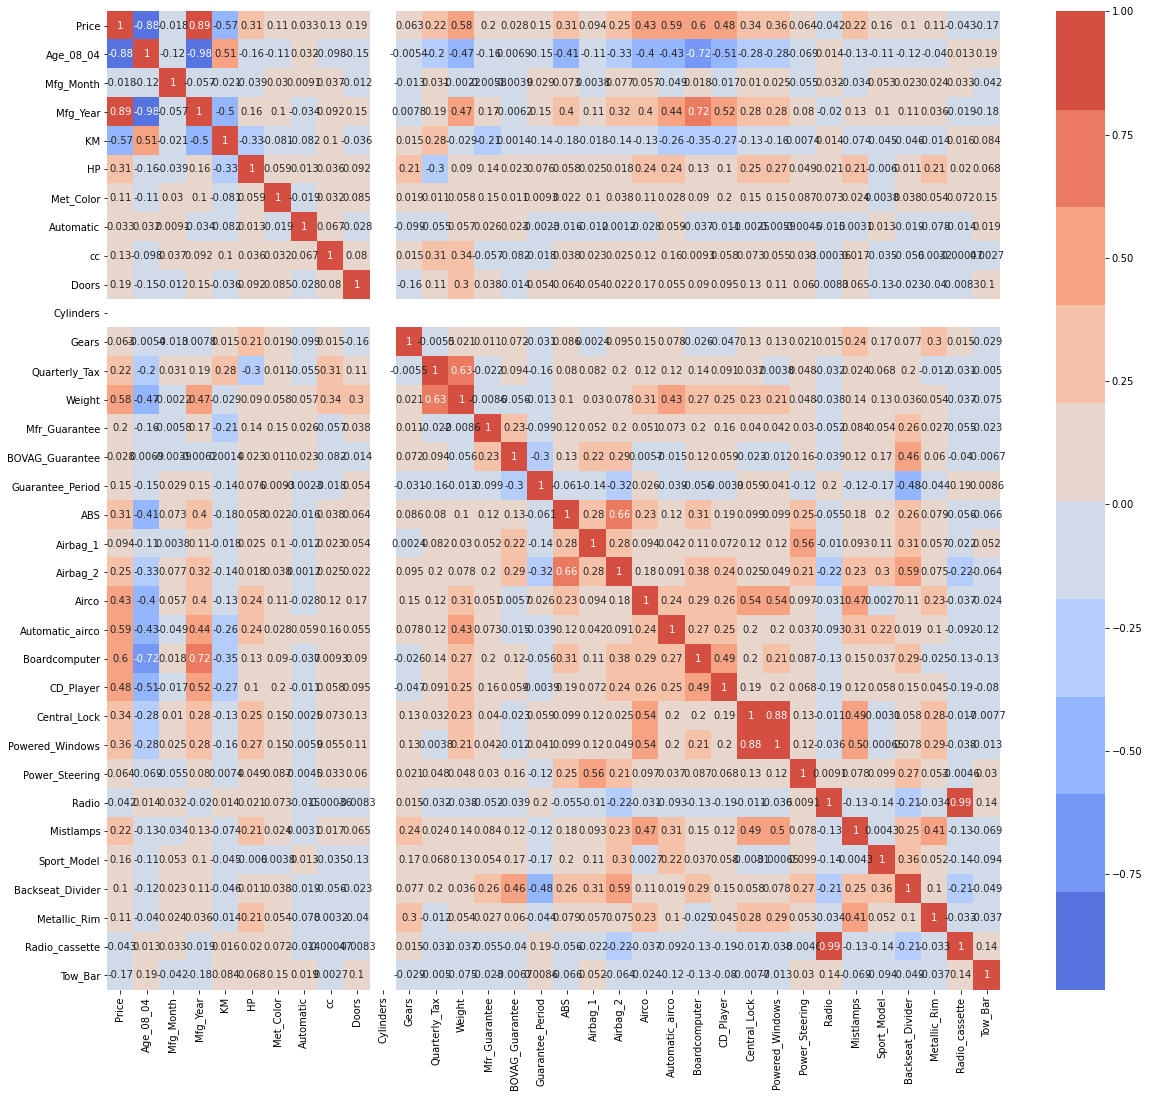

In [28]:
plt.figure(figsize=(20,18))
sns.heatmap(data.corr(), cmap=sns.color_palette("coolwarm",10), annot=data.corr())
#우리가 이제 p-value를 가지고 제거했었는데 또 다른 방법으로 제거하는 방법이 있다.
#input 데이터의 correlation를 봐서 이 correlation이 높은 얘들을 제거하는 방식도 있다.
#그것을 왜 하냐면  우리가 multiple regression에서 베타를 추정하면 b=(X^TX)^-1XY 라는 해가 
#나왔다.이게 반드시 구해지지 않는다고 했었다. 왜냐면 X^TX가 항상 inverse가 안 구해진다
#언제냐면 이 X^TX가 covariance matrix인데 이 변수 간의 상관관계가 굉장히 높을 때 이것이 
#안 구해진다. 변수 간에 상관 관계가 높을 때 inverse가 안 구해지는 것이다.
#그래서 특히 선형회귀는 우리가 이 data.corr()를 이용해서 이것이 높은 것을 제거하는 것이다
#dataframework니까 .corr() 쓰면 correlation이 변수별로 구해진다.
#파랑색은 - 고 빨강색은 corr이 큰 녀석들이 이렇게 나온다. 

In [29]:
data.corr()
#이렇게 변수별 correlation를 구할 수 있다.
#자기 자신은 1이다. 그리고 각각 변수들 간에 비교해서 corr를 구한다. 이것을 
#시각화하기 위해서 히트맵을 쓴다.

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
Price,1.000000,-0.876590,-0.018138,0.885159,-0.569960,0.314990,0.108905,0.033081,0.126389,0.185326,...,0.343458,0.356518,0.064275,-0.041887,0.222083,0.164121,0.102569,0.108564,-0.043179,-0.172369
Age_08_04,-0.876590,1.000000,-0.123255,-0.983661,0.505672,-0.156622,-0.108150,0.031717,-0.098084,-0.148359,...,-0.279631,-0.283856,-0.069192,0.013791,-0.126895,-0.110988,-0.116751,-0.040045,0.012857,0.188720
Mfg_Month,-0.018138,-0.123255,1.000000,-0.057416,-0.020630,-0.039312,0.030266,0.009146,0.037387,-0.012069,...,0.010055,0.025185,-0.055495,0.031601,-0.033504,0.052789,0.023245,0.023506,0.032576,-0.042170
Mfg_Year,0.885159,-0.983661,-0.057416,1.000000,-0.504974,0.164697,0.103310,-0.033567,0.091892,0.151442,...,0.279490,0.280996,0.079676,-0.019607,0.133737,0.102080,0.113237,0.036022,-0.018844,-0.182206
KM,-0.569960,0.505672,-0.020630,-0.504974,1.000000,-0.333538,-0.080503,-0.081854,0.102683,-0.036197,...,-0.125177,-0.156242,0.007397,0.013661,-0.074327,-0.044784,-0.045658,-0.013599,0.015770,0.084153
HP,0.314990,-0.156622,-0.039312,0.164697,-0.333538,1.000000,0.058712,0.013144,0.035856,0.092424,...,0.250122,0.265593,0.048850,0.020998,0.210571,-0.006027,0.010908,0.206784,0.019919,0.068271
Met_Color,0.108905,-0.108150,0.030266,0.103310,-0.080503,0.058712,1.000000,-0.019335,0.031812,0.085243,...,0.153307,0.145147,0.086544,0.072756,0.023821,0.003779,0.037741,0.053829,0.071530,0.148536
Automatic,0.033081,0.031717,0.009146,-0.033567,-0.081854,0.013144,-0.019335,1.000000,0.066740,-0.027654,...,-0.002502,-0.005864,-0.004469,-0.014600,0.003077,0.013175,-0.018876,-0.078095,-0.014150,0.018786
cc,0.126389,-0.098084,0.037387,0.091892,0.102683,0.035856,0.031812,0.066740,1.000000,0.079903,...,0.072634,0.055299,0.032933,-0.000361,0.017326,-0.035195,-0.055711,0.003236,-0.000470,0.002725
Doors,0.185326,-0.148359,-0.012069,0.151442,-0.036197,0.092424,0.085243,-0.027654,0.079903,1.000000,...,0.132092,0.107626,0.059792,-0.008318,0.064705,-0.129881,-0.022542,-0.039555,-0.008265,0.102292


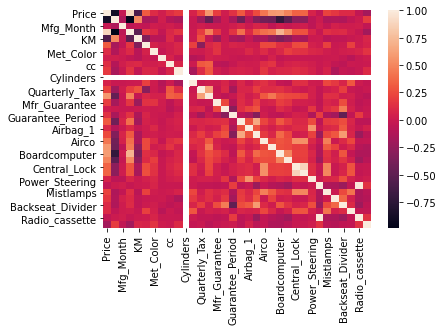

In [30]:
sns.heatmap(data.corr())
#이렇게 써도 된다. + 로 갈수록 correlation이 낮은 것이다.

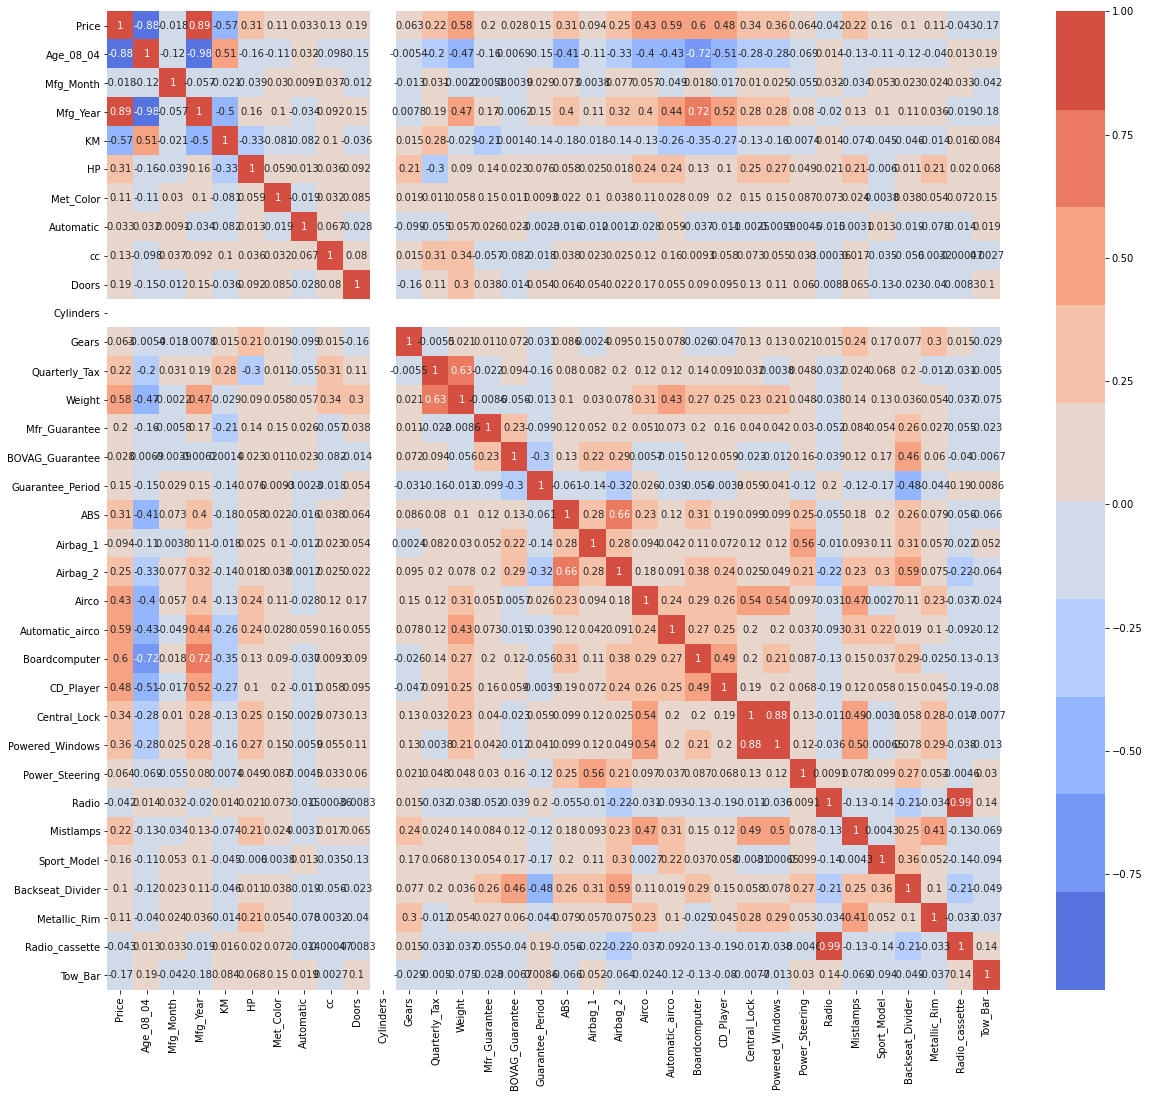

In [37]:
plt.figure(figsize=(20,18))
sns.heatmap(data.corr(), cmap=sns.color_palette("coolwarm",10), annot=data.corr())
#아래 히트맵을 보면 이제 좀 상관관계가 큰거 같아서 제거해야 하는 변수들이 보인다.

In [41]:
train_data_new2=train_data.drop(['Radio_cassette', 'Central_Lock'], axis=1)
#지금 보면 맨 아래에서 두번째 줄에 Radio_cassette와 Radio가 빨강색으로 칠해져 있는데
#이 둘 중에 라디오 카세트를 제거한 것이고 나머지도 central lock도 제거한 것이다.
#눈으로 보고 제거할 수도 있지만 여기서 어떤 기준을 정해서 0.7보다 높은 것 제거하겠다
#이런 식으로 기준을 넣어서 제거할 수도 있다.
test_data_new2=test_data.drop(['Radio_cassette', 'Central_Lock'], axis=1)


### 2-2. 변수 제거 후 모델 학습 결과 확인

In [42]:
lm_new2=sm.OLS(train_data_new2['Price'], train_data_new2.drop('Price', axis=1))
lm_new2_trained=lm_new2.fit()
lm_new2_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     341.9
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        00:29:05   Log-Likelihood:                -8454.6
No. Observations:                1005   AIC:                         1.697e+04
Df Residuals:                     975   BIC:                         1.712e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age_08_04         -113.2860      4.208    -26.920      0.000    -121.544    -105.028
Mfg_Month          -97.4813     10.864     -8.973      0.000    -118.801     -76.162
Mfg_Year             1.1150      0.807      1.381      0.167      -0.469       2.699
KM                  -0.0190      0.001    -15.497      0.000      -0.021      -0.017
HP                  25.2921      2.890      8.753      0.000      19.622      30.963
Met_Color          -49.0272     79.252     -0.619      0.536    -204.552     106.497
Automatic          275.0142    162.011      1.698      0.090     -42.915     592.944
cc                  -0.1240      0.077     -1.602      0.109      -0.276       0.028
Doors               68.3020     41.086      1.662      0.097     -12.325     148.929
Cylinders           -0.0328      0.002    -14.568      0.000      -0.037      -0.028
Gears              155.4897    193.565      0.803      0.422    -224.362     535.341
Quarterly_Tax        8.0762      1.404      5.753      0.000       5.321      10.831
Weight              10.7445      1.240      8.666      0.000       8.311      13.178
Mfr_Guarantee      304.0128     77.770      3.909      0.000     151.397     456.629
BOVAG_Guarantee    653.1579    134.639      4.851      0.000     388.941     917.374
Guarantee_Period    62.9385     13.874      4.536      0.000      35.711      90.166
ABS               -432.1968    134.521     -3.213      0.001    -696.182    -168.212
Airbag_1           239.0765    254.311      0.940      0.347    -259.983     738.136
Airbag_2            20.6406    135.455      0.152      0.879    -245.177     286.458
Airco              252.8406     92.934      2.721      0.007      70.466     435.215
Automatic_airco   2730.8447    206.241     13.241      0.000    2326.117    3135.572
Boardcomputer     -338.6340    124.672     -2.716      0.007    -583.290     -93.978
CD_Player          275.5978    106.161      2.596      0.010      67.268     483.928
Powered_Windows    332.5929     94.087      3.535      0.000     147.957     517.229
Power_Steering    -183.4340    275.962     -0.665      0.506    -724.982     358.114
Radio              -71.2473    109.930     -0.648      0.517    -286.973     144.479
Mistlamps          -17.7061    114.072     -0.155      0.877    -241.561     206.149
Sport_Model        280.0371     92.206      3.037      0.002      99.092     460.982
Backseat_Divider   -72.5283    131.366     -0.552      0.581    -330.320     185.264
Metallic_Rim        34.6622    100.026      0.347      0.729    -161.629     230.954
Tow_Bar           -249.0989     84.698     -2.941      0.003    -415.310     -82.888
==============================================================================
Omnibus:                       67.327   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.0

### 2-3. 변수 제거 후 모델 예측성능 (학습/테스트) 확인

In [43]:
train_pred_new2 = lm_new2_trained.predict(train_data_new2.drop(['Price'], axis=1))

print('Training MSE: {:.3f}'.format(mean_squared_error(train_data_new2['Price'], train_pred_new2)))
print('Training RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(train_data_new2['Price'], train_pred_new2))))
print('Training MAE: {:.3f}'.format(mean_absolute_error(train_data_new2['Price'], train_pred_new2)))
print('Training MAPE: {:.3f}'.format(mean_absolute_percentage_error(train_data_new2['Price'], train_pred_new2)))


Training MSE: 1187198.601
Training RMSE: 1089.586
Training MAE: 812.332
Training MAPE: 8.263


## 변수 변환

### 반응변수($\mathbf{y}$)에 로그 / 제곱근 등의 변환 적용하고 모델 성능 확인

In [45]:
test_pred_new2=lm_new2_trained.predict(test_data_new2.drop(['Price'], axis=1))
print('Testing MSE: {:.3f}'.format(mean_squared_error(test_data_new2['Price'], test_pred_new2)))
print('Testing RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(test_data_new2['Price'], test_pred_new2))))
print('Testing MAE: {:.3f}'.format(mean_absolute_error(test_data_new2['Price'], test_pred_new2)))
print('Testing MAPE: {:.3f}'.format(mean_absolute_percentage_error(test_data_new2['Price'], test_pred_new2)))



Testing MSE: 1424446.203
Testing RMSE: 1193.502
Testing MAE: 879.449
Testing MAPE: 8.542


In [ ]:
#Linear Regression은 여기까지만 하겠다